# CA Time Series 

In [245]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [192]:
#Importing the data
ts6_data = pd.read_csv("ts6.csv")

Checking the 5 first rows of the dataset

In [195]:
ts6_data.head()

,Unnamed: 0,x
0,1,303.996674
1,2,302.869995
2,3,296.666656
3,4,289.913330
4,5,296.453339


In [197]:
ts6_data.index

RangeIndex(start=0, stop=401, step=1)

In [200]:
print(ts6_data.describe())

       Unnamed: 0           x
count  401.000000  401.000000
mean   201.000000  215.988071
std    115.902977   44.187797
min      1.000000  108.099998
25%    101.000000  184.309998
50%    201.000000  214.240005
75%    301.000000  251.449997
max    401.000000  309.070007


In [204]:
ts6_data.dtypes

Unnamed: 0      int64
x             float64
dtype: object

x: the variable, unnamed:0 looks to be the index

Spliting the data in train and test

In [208]:
ts6_train, ts6_test = train_test_split( ts6_data, test_size=0.2, random_state=42)

Checking for missing values

In [211]:
print(ts6_train.isnull().sum())

Unnamed: 0    0
x             0
dtype: int64


Checking for duplicate values

In [214]:
print(ts6_train.index.duplicated().sum())

0


Setting the index correctly

In [217]:
ts6_train = ts6_train.set_index("Unnamed: 0")
ts6_train.index.name = "Time"

<Axes: xlabel='Time'>

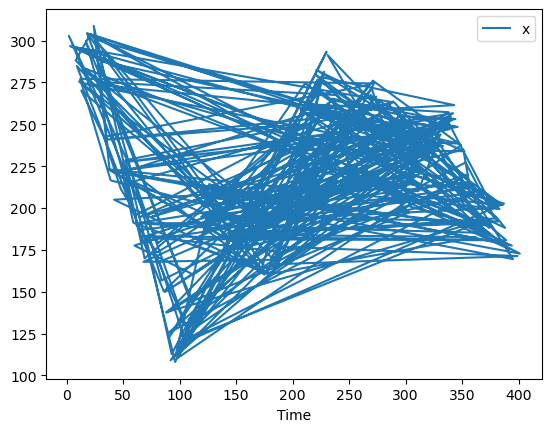

In [219]:
ts6_train.plot()

### Stationarity

The train data don't look to have a pattern, the index its updated for the name time, instead of unnamed. Continue with the test to check stationarity.

In [231]:
print(adfuller(ts6_train["x"]))

(-18.53228437044017, 2.1023962318541785e-30, 0, 319, {'1%': -3.4510167751522642, '5%': -2.87064334231426, '10%': -2.5716201744283174}, 3139.4562672961265)


The p-value is the second item in the list, in this case, its 2.1023962318541785e-30. Meaning that we reject the H0, and the time series is stationary.

Checking the first difference of the series

In [237]:
FirstDifference = (ts6_train["x"] - ts6_train["x"].shift(1)).dropna()

<Axes: xlabel='Time'>

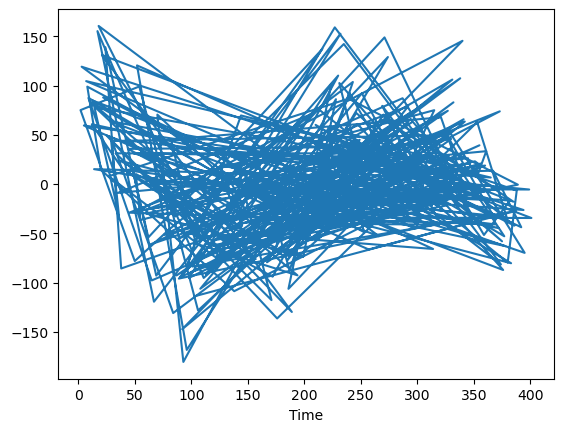

In [239]:
FirstDifference.plot()

In [241]:
round(adfuller(FirstDifference)[1],3)

0.0

the p-value is now less than 0.001, we reject the null hypothesis and conclude that the first differenced series is stationary.

Creating a plot to see the autocorrelation function and partial autocorrelation function plots to try to determine the orders of p and q, the autoregressive and moving average terms.

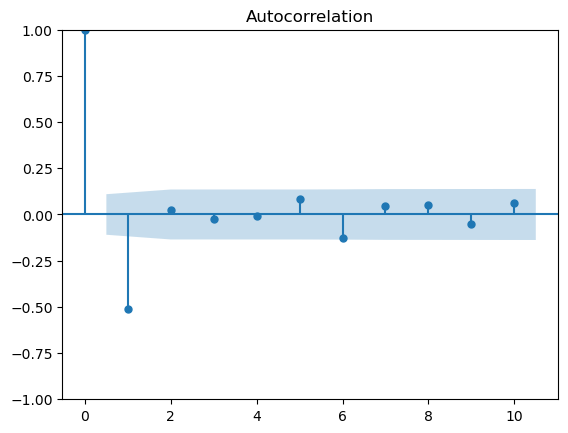

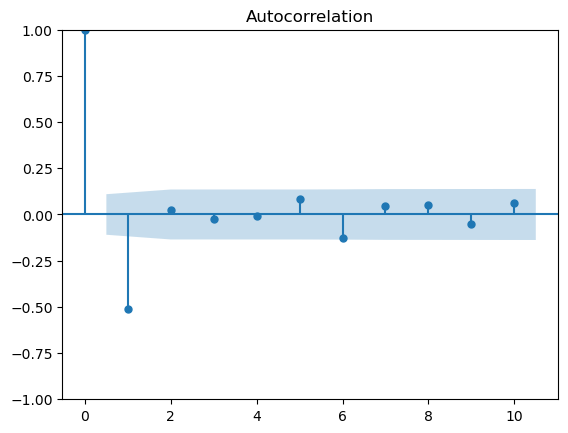

In [247]:
plot_acf(FirstDifference, lags=10)